In [1]:
#!/usr/bin/env python
# coding: utf-8



# In[2]:


import numpy as np
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import json
import gc
from mpl_toolkits.axes_grid1 import make_axes_locatable


class CircuitModel:

    def __init__(self, arg_rseed, arg_n_syllables): 
        """ Initialise the individual simulation. """

        
        # In[6]:


        gc.collect()

        # Parameters
        # ---------- #
        # rSeed = np.random.randint(0, 1e7)       # Random seed parameters
        self.rSeed = arg_rseed #3971#87654 #87 #764567#1234567
        np.random.seed(self.rSeed)

        self.results_path = 'Results/'

        # Architecture

        # In[7]:


        self.HVC_size = 100                            # Layer parameters
        self.BG_size = 50
        self.RA_size = 100
        self.MC_size = 2


        self.n_RA_clusters = self.MC_size
        self.n_BG_clusters = 5


        # In[8]:


        self.BG_noise_mean = 0.00                    # Activation function parameters
        self.BG_noise_std = .2 


        # In[9]:


        self.soft_bound = 0                          # Weight parameters
        self.Wmin_f, self.Wmax_f = 0, 1
        # Wmin, Wmax = 0, 1
        self.Wmin_RL, self.Wmax_RL = -1, 1
        self.Wmin_Heb, self.Wmax_Heb = -1, 1
        self.Wepsilon = 0.01


        # In[10]:


        self.n_bits = int(0.1 * self.HVC_size)                              # no. of bits active in each syllable encoding
        self.n_syllables = arg_n_syllables          # syllables possible without overlap in encoding


        # In[11]:

        self.n_daily_motifs = 1000
        self.n_days = 60
        self.n_trial_per_syll = self.n_daily_motifs * self.n_days #121000
        self.n_intact_trials = self.n_trial_per_syll * self.n_syllables
        self.n_lesioned_days = 1
        self.n_total_trials = self.n_intact_trials + self.n_lesioned_days * self.n_daily_motifs * self.n_syllables


        # In[12]:


        self.Hebbian_learning = HEBBIAN_LEARNING = 1
        self.Hebbian_rule = 3                        # 1 -> Hebbian, 2 -> iBCM, 3 -> Oja
        self.BG_influence = 1
        self.eta = ETA = 0.1
        self.pPos = 0.00003
        # pDec = 0.0001
        # tau = 1500                              # only used in iBCM


        # In[13]:


        self.reward_window = 25                      # Reward calculation parameters
        self.reward_sigma = 0.2


        # In[14]:


        # MC_sig_slope = 1#*2
        # BG_sig_slope = 1
        # arg_steepFactor = 30.0
        self.RA_sig_slope = 30
        self.RA_sig_mid = 0
        # BG_sig_mid = 0
        # MC_sig_mid = 0

        self.build_syllable_encoding()





# In[3]:


    def sigmoid_neg(self, x, m=5, a=0.5):
        return (2 / (1 + np.exp(-1*(x-a)*m))) - 1

    def sigmoid(self, x, m=5, a=0.5):
        return 1 / (1 + np.exp(-1*(x-a)*m))

    def sliding_window(self, Z, window):
        shape = Z.shape[:-1] + (Z.shape[-1] - window + 1, window)
        strides = Z.strides + (Z.strides[-1],)
        return np.lib.stride_tricks.as_strided(Z, shape=shape, strides=strides)


# In[4]:


# def lnorm(x):
#     return (x-np.mean(x))/np.sqrt(np.var(x)+1e-7) 

# def layer_norm(x, n_clusters=1):
#     s = x.size
#     cs = s//n_clusters

#     for nc in np.arange(n_clusters):
#         x[nc*cs:(nc+1)*cs] = lnorm(x[nc*cs:(nc+1)*cs])
    
#     return x


# In[5]:


    def generate_gradient(self, n=256, contour_type='Artificial'):
            """ Redirects to the function that generates the desired contour type """
            
            if contour_type == 'Syrinx': return self.generate_gradient_syrinx(n)
            elif contour_type == 'Artificial': return self.generate_gradient_artificial(n)
            else: print("Contour type not specified (Syrinx/Artificial).")

                
    def generate_gradient_artificial(self, n=256, n_distractors=40):
            """ Creates the overall reward contour by combining several gaussians. """
            
            # No. of local optima
            n_hills = n_distractors

            # Target i.e. global optima
            target_theta = np.random.uniform(0,2*np.pi)
            target_r = np.random.uniform(0,1)
            targetpos = target_r*np.cos(target_theta), target_r*np.sin(target_theta)
            hills = [self.hill(0.3, targetpos)] # chosen sigma=0.3

            # n_hills distractors (0.4 < σ < 0.7) i.e. local optima
            for i in range(n_hills):
                hills.append(self.hill(np.random.uniform(0.4, 0.7)))

            # Build gradient landscape
            Z = np.zeros((n,n))
            for (center, sigma) in hills:
                Z = np.maximum(Z, self.gaussian(n, center, sigma))
                # Z = Z + gaussian(n, center, sigma)    # For a smoother reward profile    
            
            return  Z / Z.max(), targetpos
    
    def hill(self, sigma=0.1, center=None):
            """ Randomly assigns the mean and std deviation for the hills in the reward contour. """

            if center is None:
                r = np.sqrt(np.random.uniform(0.0, 1.0))
                a = np.random.uniform(0, 2*np.pi)
                center = r*np.cos(a), r*np.sin(a)

            return center, sigma
        
    def gaussian(self, n=128, center=(0,0), sigma=0.1):
            """ Creates a 2D gaussian distribution, given the center coordinates and std deviation. """

            X, Y = np.meshgrid(np.linspace(-1, +1, n), np.linspace(-1, +1, n))
            x0, y0 = center
            D = np.sqrt((X-x0)**2/(2*sigma**2) + (Y-y0)**2/(2*sigma**2))

            return 1/(2*np.pi*sigma**2)*np.exp(-D)
        
    def read_gradient(self, Z, p):
            """ Returns height of reward profile at given position. """

            x = min(max(p[0], -1), 1)
            y = min(max(p[1], -1), 1)
            col = int(((x + 1)/2) * (Z.shape[1]-1))
            row = int(((y + 1)/2) * (Z.shape[0]-1))

            return Z[row, col]


    def build_syllable_encoding(self):
        # In[22]:


        self.syllable_encoding = {}
        self.syllables = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
        self.syllables = self.syllables[:self.n_syllables]                       # ensure n_samples >= len(syllables)

        for i in range(self.n_syllables):
            inputs = np.zeros(self.HVC_size)
            inputs[i * self.n_bits:(i + 1) * self.n_bits] = 1
            self.syllable_encoding[self.syllables[i]] = inputs

        # outputs = np.random.uniform(min_possible_output+0.05, max_possible_output-0.05, (n_samples, MC_size))

        self.syllable_outputs = {}
        self.syllable_contours = {}
        for i in range(self.n_syllables):
        #     syllable_outputs[syllables[i]] = outputs[i] #(np.cos(theta[i])+1)/2, (np.sin(theta[i])+1)/2 
            contour, target = self.generate_gradient()
            self.syllable_contours[self.syllables[i]] = contour
            self.syllable_outputs[self.syllables[i]] = target

        # print('Target', syllable_outputs)
        # target2 = np.random.uniform(min_possible_output+0.05, max_possible_output-0.05)


    def build_and_simulate(self):
        # In[15]:

        # Model build
        # ----------- #
        HVC = np.zeros(self.HVC_size)
        RA = np.zeros(self.RA_size)
        MC = np.zeros(self.MC_size)
        BG = np.zeros(self.BG_size)


        W_HVC_RA = np.zeros((self.HVC_size, self.RA_size), float) #+ Wepsilon

        # W_RA_MC = np.random.uniform(-1 + Wepsilon, Wmax_f - Wepsilon, (RA_size, MC_size))

        W_HVC_BG = np.random.uniform(self.Wmin_RL + self.Wepsilon, self.Wmax_RL - self.Wepsilon, (self.HVC_size, self.BG_size))
        W_RA_MC = np.random.uniform(self.Wmin_f + self.Wepsilon, self.Wmax_f - self.Wepsilon, (self.RA_size, self.MC_size))

        W_BG_RA = np.random.uniform(self.Wmin_f + self.Wepsilon, self.Wmax_f - self.Wepsilon, (self.BG_size, self.RA_size))


        # In[16]:


        # Segregated pathways between RA and MC
        RA_cluster_size = self.RA_size//self.n_RA_clusters
        BG_cluster_size = self.BG_size//self.n_BG_clusters

        for i in range(self.n_RA_clusters):
            W_RA_MC[i*RA_cluster_size : (i+1)*RA_cluster_size] *= np.diag(np.ones(self.n_RA_clusters, int))[i]

        # Segregated pathways between BG and RA
        for i in range(self.n_BG_clusters):
            segPath = np.diag(np.ones(self.n_BG_clusters, int))[i]
            W_BG_RA[i*BG_cluster_size : (i+1)*BG_cluster_size] *= [j for j in segPath for r in range(self.RA_size//self.n_BG_clusters)]

        # In[17]:


        # HVC = np.zeros((HVC_size))
        # HVC[:n_bits] = 1

        # W_HVC_RA_temp = np.zeros((HVC_size, RA_size)) + Wmin_Heb

        # RA[...] = np.dot(HVC, W_HVC_RA_temp) / n_bits
        # min_RA = np.copy(RA)
        # min_RA_sig_in = np.min(RA)

        # W_HVC_RA_temp = np.zeros((HVC_size, RA_size)) + Wmax_Heb

        # RA[...] = np.dot(HVC, W_HVC_RA_temp) / n_bits #HVC_size
        # max_RA = np.copy(RA)
        # max_RA_sig_in = np.max(RA)

        # ## calc RA slope
        # RA_sig_mid = (min_RA_sig_in + max_RA_sig_in)/2.0
        # RA_sig_slope = arg_steepFactor / (max_RA_sig_in - min_RA_sig_in)
        # print("RA_sig_mid", RA_sig_mid, "RA_sig_slope", RA_sig_slope)

        # # BG_sig_slope = RA_sig_slope
        # BG_sig_mid = RA_sig_mid
        # MC_sig_mid = 0

        # RA[...] = sigmoid_neg(min_RA, RA_sig_slope, RA_sig_mid)

        # MC = np.dot(RA, W_RA_MC) / RA_cluster_size
        # MC = sigmoid(MC, MC_sig_slope, MC_sig_mid) * 2 - 1

        # min_possible_output = min(MC)

        # RA[...] = sigmoid_neg(max_RA, RA_sig_slope, RA_sig_mid)

        # MC = np.dot(RA, W_RA_MC) / RA_cluster_size
        # MC = sigmoid(MC, MC_sig_slope, MC_sig_mid) * 2 - 1

        # max_possible_output = max(MC)

        # output_range =  max_possible_output - min_possible_output

        # print("Output range:", output_range, min_possible_output, max_possible_output)


        # In[18]:


        # min_possible_output, max_possible_output = -1, 1
        # output_range = 2


        # In[19]:


        # RA_sig_mid, RA_sig_slope = 0.0, 50.0
        # BG_sig_mid, BG_sig_slope = 0.0, 50.0
        # MC_sig_mid, MC_sig_slope = 0.0, 10.0

        # output_range, min_possible_output, max_possible_output = 0.9784039305472212, 0.010798034726389407, 0.9892019652736106


        # In[20]:


        # BG_min = np.zeros((BG_size))
        # RA_min = np.dot(BG_min, W_BG_RA)/BG_cluster_size #/ [(RA_temp[k*cluster_size:(k+1)*cluster_size]>.5).sum() for k in range(n_clusters)]
        # BG_max = np.ones((BG_size))
        # RA_max = np.dot(BG_max, W_BG_RA)/BG_cluster_size #/ [(RA_temp[k*cluster_size:(k+1)*cluster_size]>.5).sum() for k in range(n_clusters)]
        # RA_sig_mid = np.mean([max(RA_max), min(RA_min)])


        # In[21]:


        # RA_min = np.zeros((RA_size))
        # MC_min = np.dot(RA_min, W_RA_MC)/RA_cluster_size #/ [(RA_temp[k*cluster_size:(k+1)*cluster_size]>.5).sum() for k in range(n_clusters)]
        # RA_max = np.ones((RA_size))
        # MC_max = np.dot(RA_max, W_RA_MC)/RA_cluster_size #/ [(RA_temp[k*cluster_size:(k+1)*cluster_size]>.5).sum() for k in range(n_clusters)]
        # MC_sig_mid = np.mean([max(MC_max), min(MC_min)])





        # In[23]:


        # Tracking
        # ---------- #


        self.R = np.zeros((self.n_syllables, self.n_total_trials//self.n_syllables))                              # keeps track of reward
        self.E = np.zeros(self.n_total_trials)                              # keeps track of error
        self.E_norm = np.zeros(self.n_total_trials)                         # keeps track of normalised error
        self.W = np.zeros((self.n_total_trials, self.n_bits*self.BG_size))             # to plot HVC-BG weights
        self.W_HR = np.zeros((self.n_total_trials, W_HVC_RA.size))          # to plot HVC-RA weights
        self.T = np.zeros(self.RA_size)
        self.S_MO = np.zeros((self.n_total_trials, self.MC_size))
        self.S_T = np.zeros((self.n_total_trials, self.MC_size))
        self.S_cc = np.zeros((self.n_total_trials))
        self.S_RA = np.zeros((self.n_total_trials, self.RA_size))
        self.S_BG = np.zeros((self.n_total_trials, self.BG_size))
        self.S_dW1_sum = np.zeros((self.n_total_trials))


        # In[24]:


        # syll = "A"
        # target = syllable_outputs[syll]
        # HVC[...] = syllable_encoding[syll]

        # nt = 0
        # nt_per_iter = 1
        # n_motifs = int(self.n_total_trials/(self.n_samples*nt_per_iter)) 


        # In[25]:


        # x = np.linspace(-.5,1.5,1000)
        # y = sigmoid(x, 10, .5)
        # plt.plot(x,y)


        # In[26]:

        nt = 0
        for n_day in np.arange(self.n_days + self.n_lesioned_days):
            day_dW1_sum = 0
            if n_day >= self.n_days: self.BG_influence = 0
            
            for n_motif in np.arange(self.n_daily_motifs):
                
                for n_syll in np.arange(self.n_syllables):
                    
                    syll = self.syllables[n_syll]
                    n_iter = int(n_day * self.n_daily_motifs + n_motif)

                    target = self.syllable_outputs[syll]
                    contour = self.syllable_contours[syll]
                    HVC[...] = self.syllable_encoding[syll]
                    
                
                    # Compute BG
                    BG[...] = np.dot(HVC, W_HVC_BG) / self.n_bits
                    BG_noise = np.random.uniform(-1, 1, self.BG_size) * self.BG_noise_std
                    BG += BG_noise
                    BG = np.minimum(1, np.maximum(-1, BG))


                    # Compute RA activity with BG
                    RA_HVC = np.dot(HVC, W_HVC_RA) / self.n_bits * self.Hebbian_learning
                    RA_BG = np.dot(BG, W_BG_RA)/np.sum(np.abs(W_BG_RA), axis=0) * self.BG_influence
                    RA_BG = RA_BG * 2
                    RA_in =  RA_HVC + RA_BG
                    RA = self.sigmoid_neg(RA_in, self.RA_sig_slope, self.RA_sig_mid)


                    # Compute MC activity
                    MC = np.dot(RA, W_RA_MC)/np.sum(W_RA_MC, axis=0)


                    # Compute error and reward
                    reward = self.read_gradient(contour, MC)

                    # if nt == 0: print("First trial", "MC:", MC, "error:", E[0], "Norm error:", E_norm[0])

                    # Computing mean reward
                    R_ = 0
                    if n_iter > self.reward_window: R_ = self.R[n_syll, n_iter - self.reward_window:n_iter].mean()
                    elif n_iter > 0: R_ = self.R[n_syll, :n_iter].mean()

            #         Weight update
                    dW1 = self.eta * (reward - R_) * HVC.reshape(self.HVC_size, 1) * (BG) * self.BG_influence
                    if self.Hebbian_rule == 1:   dW2 = self.pPos * HVC.reshape(self.HVC_size, 1) * (RA) * self.Hebbian_learning
                    elif self.Hebbian_rule == 3:   dW2 = self.pPos * ((HVC.reshape(self.HVC_size, 1) * RA) - (HVC.reshape(self.HVC_size, 1) * RA * RA * W_HVC_RA)) * self.Hebbian_learning                                                 # Oja learning rule                                                                  RA_size) * Hebbian_learning
                    else:   dW2 = self.pPos * self.HVC.reshape(self.HVC_size, 1) * (RA_BG) * self.Hebbian_learning

                    day_dW1_sum += np.mean(np.abs(dW1 * (self.Wmax_RL - W_HVC_BG) * (W_HVC_BG - self.Wmin_RL)))

                    if self.soft_bound == 1:
                        W_HVC_BG += dW1 * (Wmax_RL - W_HVC_BG) * (W_HVC_BG - self.Wmin_RL)
                        W_HVC_RA += dW2 * (self.Wmax_Heb - W_HVC_RA) * (W_HVC_RA - self.Wmin_Heb)
                    else:
                        W_HVC_BG = np.minimum(self.Wmax_RL, np.maximum(self.Wmin_RL, W_HVC_BG + dW1))
                        W_HVC_RA = np.minimum(self.Wmax_Heb, np.maximum(self.Wmin_Heb, W_HVC_RA + dW2))
                    
                    # for plotting purposes
                    nt = n_iter * self.n_syllables + n_syll
                    self.R[n_syll, n_iter] = reward

                    self.W[nt] = W_HVC_BG[:self.n_bits,:].ravel()                                
                    self.W_HR[nt] = W_HVC_RA.ravel()

                    self.S_MO[nt] = MC.ravel()
                    self.S_T[nt] = target
                    self.S_RA[nt] = RA
                    self.S_BG[nt] = BG

                    self.S_dW1_sum[nt] = day_dW1_sum

    
    
            # Night shuffling of HVC-BG synapses
            potentiation_factor = np.minimum(day_dW1_sum/self.n_syllables, 1)    

            for sleep_k in np.arange(1000):
                HVC[:(self.n_bits*self.n_syllables)] = 1
                BG_noise = np.random.uniform(-1, 1, self.BG_size) * self.BG_noise_std * 1
                dW_night = self.eta * HVC.reshape(self.HVC_size, 1) * (BG_noise) * self.BG_influence * ((1 - potentiation_factor))
                if self.soft_bound == 1:
                    W_HVC_BG += dW_night * (self.Wmax_RL - W_HVC_BG) * (W_HVC_BG - self.Wmin_RL)
                else:
                    W_HVC_BG = np.minimum(self.Wmax_RL, np.maximum(self.Wmin_RL, W_HVC_BG + dW_night))

                

        performance_score = {}
        for n_syll in np.arange(self.n_syllables):
            performance_score[self.syllables[n_syll]] = np.mean(self.R[n_syll, self.n_trial_per_syll-5*self.n_daily_motifs:self.n_trial_per_syll])

        return performance_score

# In[27]:


# get_ipython().run_line_magic('matplotlib', 'inline')


# In[28]:


# dRd = np.zeros((n_total_trials))
# for i in np.arange((n_total_trials//2000)):
#     ntt = i*2000
#     r = np.var(R[n_syll][ntt:ntt+2000])
#     dRd[ntt] = r 

    def plot_results(self):

        self.plot_potentiation_factor()
#         self.plot_progression()
        self.plot_trajectory()

    def plot_potentiation_factor(self):

        # Plot 1: For daily potentiation factor

        plt.figure(figsize=(12, 8))
        ax = plt.subplot(1, 1, 1)

        ax.plot(self.R.T.flatten(), marker=',', linewidth=0)
        ax.plot((1-self.S_dW1_sum), marker=',', linewidth=0)
        # plt.ylim(-.01,1)

        plt.tight_layout()
        plt.savefig(self.results_path + '/' + str(self.rSeed) + "_potentiation_factor.png")
        plt.close()


    def plot_progression(self):


        # In[29]:


        # Display results
        # ---------------

        # Plot 2: For individual values

        plt.figure(figsize=(12, 8))
        plt.rc("ytick", labelsize="small")
        plt.rc("xtick", labelsize="small")

        n_subplots = 6

        ax = plt.subplot(n_subplots, 1, 1)
        ax.set_title("Testing RL with normalised sigmoid")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Plot all trial rewards
        T = np.arange(len(self.R.T.flatten()))
        ax.plot(T, self.R.T.flatten(), marker="o", markersize=1.5, linewidth=0, alpha=.25,
                color="none", markeredgecolor="none", markerfacecolor="black")

        # Plot a sliding average over n=50 trials
        # n = 4 * reward_window
        # n = reward_window
        # Sm = np.std(sliding_window(R.T.flatten(), n), axis=-1)
        # Rm = np.mean(sliding_window(R.T.flatten(), n), axis=-1)
        # T = n - 1 + np.arange(len(Rm))
        # ax.plot(T, Rm, linewidth=0.75, color="black")
        # ax.text(T[-1], Rm[-1], " %.2f" % Rm[-1], color="black",
        #         ha="left", va="center", fontsize="small")

        # ax.fill_between(T, Rm - Sm, Rm + Sm, color="black", alpha=0.1)
        ax.set_xlabel("Trial #")
        # ax.set_ylabel("Averaged reward (n=%d)" % n)
        ax.set_ylim(0, 1)

        # ax.axvline(n, linestyle="--", linewidth=0.5, color="black")

        # ax = ax.twinx()
        # ax.spines['top'].set_visible(False)
        # ax.set_ylabel('Averaged error (n=%d)' % n, color='r')
        # ax.set_ylim(0, 1)
        # Em = np.mean(sliding_window(E_norm, n), axis=-1)
        # T = n - 1 + np.arange(len(Em))
        # ax.plot(T, Em, linewidth=0.75, color="red")
        # ax.text(T[-1], Em[-1], " %.2f" % Em[-1], color="red",
        #         ha="left", va="center", fontsize="small")

        # ax.fill_between(T, Em - Sm, Em + Sm, color="red", alpha=0.1)
        # ax.tick_params('y', colors="red")
        # ax.spines['right'].set_color("red")

        ax = plt.subplot(n_subplots, 1, 2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        T = np.arange(self.n_total_trials)
        ax.plot(T, self.W, color='black', alpha=.5, linewidth=0.5)
        ax.set_ylabel("HVC - BG weights")
        ax.set_ylim(self.Wmin_RL-0.1, self.Wmax_RL+0.1)

        ax = plt.subplot(n_subplots, 1, 3)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        T = np.arange(self.n_total_trials)
        ax.plot(T, self.S_BG, color='black', alpha=.5, marker=',', linewidth=0, markersize=0.5)
        ax.set_ylabel("BG output")
        ax.set_ylim(-1.1, 1.1)

        ax = plt.subplot(n_subplots, 1, 4)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        T = np.arange(self.n_total_trials)
        ax.plot(T, self.W_HR[:,::10], color='black', alpha=.5, linewidth=0.5)
        ax.set_ylabel("HVC - RA weights")
        ax.set_ylim(self.Wmin_Heb-0.1, self.Wmax_Heb+0.1) 

        ax = plt.subplot(n_subplots, 1, 5)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        T = np.arange(self.n_total_trials)
        ax.plot(T, self.S_MO, color='black', alpha=.5, marker=',', linewidth=0, markersize=0.5)
        ax.plot(T, self.S_T, color='red', marker=',', linewidth=0, markersize=0.5)
        ax.set_xlabel("Trials #")
        ax.set_ylabel("Output")
        # ax.set_ylim(-1, 1)

        # ax = plt.subplot(n_subplots, 1, 5)
        # ax.spines['right'].set_visible(False)
        # ax.spines['top'].set_visible(False)
        # T = np.arange(n_total_trials)
        # ax.plot(T, S_cc, color='black', alpha=.5, marker=',', linewidth=0, markersize=0.5)
        # ax.axhline(y=0, color='red', alpha=.5, marker=',', linewidth=0.5)
        # ax.set_ylabel("Correlation\nCoefficient")
        # ax.set_ylim(-1, 1)

        ax = plt.subplot(n_subplots, 1, 6)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        T = np.arange(self.n_total_trials)
        ax.plot(T, self.S_RA, color='black', alpha=.5, marker=',', linewidth=0, markersize=0.5)
        ax.axhline(y=0, color='red', alpha=.5, marker=',', linewidth=0.5)
        ax.set_ylabel("RA activity")
        # ax.set_ylim(-1.1, 1.1)

        # ax = plt.subplot(n_subplots, 1, 5)
        # n1 = 20
        # n2 = n_motifs * n_samples
        # grid_MO = np.zeros((n_total_trials, n1))
        # grid = np.zeros((n2, n1))
        # for i in range(n_total_trials):
        #     val = int(S_MO[i] * n1)
        #     grid_MO[i, val] = 1
        # width = int(n_total_trials/n2)
        # for i in range(n2):
        #     grid[i] = np.mean(grid_MO[i*width:(i+1)*width], axis=0)
        # ax.imshow(grid.T, interpolation='hanning', cmap='viridis', origin='lower')




        plt.tight_layout()
        plt.savefig(self.results_path + '/' + str(self.rSeed) + "_progression.png")


        # plt.show()

        plt.close()



    def plot_trajectory(self):
        # In[30]:


        for n_syll in np.arange(self.n_syllables):
            syll = self.syllables[n_syll]
            contour = self.syllable_contours[syll]
            target = self.syllable_outputs[syll]


            # In[31]:

            # Plot 3: Trajectory

            """ Plots the trajectory of the model output and cortical pathway over the simulation. """

            figure = plt.figure(figsize=(8,8))
            ax = plt.subplot(frameon=True)

            sk = self.n_syllables

            # Plot reward contour as circles around hills    
            contour_plot = ax.contourf(contour, 30, extent=[-1,1,-1,1], cmap="gray_r", alpha=.25)
            contour_plot = ax.contour(contour, 10, extent=[-1,1,-1,1], colors="black",  alpha=.5, linewidths=0.5)

            # Plot reward contour as a color plot
            im = ax.imshow(contour, vmin=0, vmax=np.max(contour), cmap='Purples', extent=[-1,1,-1,1], origin='lower')
            #         ax.invert_yaxis()                                                          # Labels read top-to-bottom

            # Plot trajectory
            ax.plot(self.S_MO[n_syll::sk,0],self.S_MO[n_syll::sk,1], color="black", lw=0, marker='.', alpha=0.2, markersize=2)
            # #         ax.plot(self.CTX[:,0],self.CTX[:,1], color="white", lw=0, marker='.', alpha=0.5, markersize=3)
            # ax.plot(CTX[::sk,0::sk],self.CTX[::sk,1::sk], color="sienna", lw=0, marker='.', alpha=0.5, markersize=4)

            # # Annotations
            ax.scatter(self.S_MO[n_syll,0], self.S_MO[n_syll,1], color="sienna", marker="o",
                       linewidths=3, facecolors="sienna", zorder=10, label='Initial point')
            ax.scatter(self.S_MO[-self.n_syllables+n_syll,0], self.S_MO[-self.n_syllables+n_syll,1], s=100, color="orange", marker="x",
                       linewidths=3, facecolors="orange", zorder=10, label='Final point')

            # Display colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.5)
            cbar = figure.colorbar(im, cax=cax, ticks=[0, .5, 1])
            cbar.set_label('Performance metric (R)', rotation=270, fontsize=25, labelpad=25)
            cbar.ax.tick_params(labelsize=20)

            #         ax.spines['top'].set_visible(False)
            #         ax.spines['right'].set_visible(False)
            ax.set_xlabel(r'$P_{\beta}$', fontsize=30)
            ax.set_ylabel(r'$P_{\alpha}$', fontsize=30)
            ax.set_xticks(np.linspace(-1, 1, 3))
            ax.set_yticks(np.linspace(-1, 1, 3))
            ax.tick_params(labelsize=25)



            # ax.legend(loc='upper left', bbox_to_anchor=[-0.1,1])

            # # Save figure
            plt.tight_layout()
            plt.savefig(self.results_path + '/' + str(self.rSeed) + '_' + syll + "_trajectory.png", rasterised=True)
            # plt.show()
            plt.close(figure)

In [2]:
def running_mean(x, N=5):
        """ Returns the running average of an array. """

        rm = np.convolve(x, np.ones(N)/N, mode='valid')
        padded_rm = np.ones(np.shape(x)) * rm[-1]
        padded_rm[:rm.size] = rm

        return padded_rm

In [8]:
def plot_reward(obj):
        
        figure, ax = plt.subplots(1, figsize=(10,5))
        
        sk = 100
        
        # Display x axis in days
        x = np.linspace(0, obj.n_days+obj.n_lesioned_days, obj.n_total_trials/sk)

#         ax.set_title("Testing RL with normalised sigmoid")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Plot all trial rewards
        ax.plot(x, obj.R.T.flatten()[::sk], linewidth=0, marker='.', color='purple', alpha=0.2, markersize=2)
        ax.plot(x, obj.R.T.flatten()[1::sk], linewidth=0, marker='.', color='purple', alpha=0.2, markersize=2)
        ax.plot(x, obj.R.T.flatten()[2::sk], linewidth=0, marker='.', color='purple', alpha=0.2, markersize=2)
        ax.plot(x, obj.R.T.flatten()[3::sk], linewidth=0, marker='.', color='purple', alpha=0.2, markersize=2)
        
#         ax.plot(x, running_mean(obj.R[0], 100)[::sk//4], color="purple", lw=0, alpha=0.75, marker='.', markersize=2, label='Motif')#, label='$\overline{R_{100}}$')
#         ax.plot(x, running_mean(obj.R[1], 100)[::sk//4], color="purple", lw=0, alpha=0.75, marker='.', markersize=2, label='Motif')#, label='$\overline{R_{100}}$')
#         ax.plot(x, running_mean(obj.R[2], 100)[::sk//4], color="purple", lw=0, alpha=0.75, marker='.', markersize=2, label='Motif')#, label='$\overline{R_{100}}$')
#         ax.plot(x, running_mean(obj.R[3], 100)[::sk//4], color="purple", lw=0, alpha=0.75, marker='.', markersize=2, label='Motif')#, label='$\overline{R_{100}}$')
        
        ax.plot(x, running_mean(obj.R[0], 100)[::sk//4], color="purple", lw=1, alpha=0.5, label='Syllable')#, label='$\overline{R_{100}}$')
        ax.plot(x, running_mean(obj.R[1], 100)[::sk//4], color="purple", lw=1, alpha=0.5)#, label='$\overline{R_{100}}$')
        ax.plot(x, running_mean(obj.R[2], 100)[::sk//4], color="purple", lw=1, alpha=0.5)
        ax.plot(x, running_mean(obj.R[3], 100)[::sk//4], color="purple", lw=1, alpha=0.5)



        
        ax.plot(x, running_mean(obj.R.T.flatten(), 100)[::sk], color="black", lw=2, alpha=1, markersize=8, label='Motif')#, label='$\overline{R_{100}}$')
#         ax.scatter(x[3999::(obj.n_daily_motifs * obj.n_syllables)], (obj.S_dW1_sum/obj.n_syllables)[3999::(obj.n_daily_motifs * obj.n_syllables)], s=1, marker=',', color='black')
        # plt.ylim(-.01,1)
    
        ax.axvline(x=60, linestyle='--', color='grey', lw=1)

        plt.tight_layout()

#         ax.fill_between(T, Rm - Sm, Rm + Sm, color="black", alpha=0.1)
        ax.set_xlabel("Days", fontsize=20)
        ax.set_ylabel("Performance metric", fontsize=20)
        ax.set_ylim(0, 1)
        ax.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)
        ax.tick_params(labelsize=15)
        ax.set_yticks([0, 1])



        
        
        
        ax.legend(bbox_to_anchor=[.925,0.25], fontsize=15, frameon=False)
        plt.tight_layout()

        # ax.axvline(n, linestyle="--", linewidth=0.5, color="black")
        
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_reward2.png")
        
        
        



In [9]:
def plot_output(obj):
        """ Plots the model output over time. """

        figure, (ax1, ax2) = plt.subplots(2,1)
        
        sk = obj.n_syllables

        # Display x axis in days
        x = np.arange(obj.n_total_trials)
        x = x/(obj.n_daily_motifs * obj.n_syllables)

        # Plot running average of cortical output (brown), BG output (grey) and total output (black)
        ax1.plot(x[::sk], running_mean(obj.S_MO[::sk,0]), color="black", lw=1, alpha=.9)
        ax2.plot(x[::sk], running_mean(obj.S_MO[::sk,1]), color="black", lw=1, alpha=.9)

        ax1.plot(x[1::sk], running_mean(obj.S_MO[1::sk,0]), color="black", lw=1, alpha=.9)
        ax2.plot(x[1::sk], running_mean(obj.S_MO[1::sk,1]), color="black", lw=1, alpha=.9)

        ax1.plot(x[2::sk], running_mean(obj.S_MO[2::sk,0]), color="black", lw=1, alpha=.9)
        ax2.plot(x[2::sk], running_mean(obj.S_MO[2::sk,1]), color="black", lw=1, alpha=.9)

        ax1.plot(x[3::sk], running_mean(obj.S_MO[3::sk,0]), color="black", lw=1, alpha=.9)
        ax2.plot(x[3::sk], running_mean(obj.S_MO[3::sk,1]), color="black", lw=1, alpha=.9)

        ax1.plot(x[::sk], obj.S_T[::sk,0], color='red', linestyle='--', linewidth=1)
        ax1.plot(x[1::sk], obj.S_T[1::sk,0], color='red', linestyle='--', linewidth=1)
        ax1.plot(x[2::sk], obj.S_T[2::sk,0], color='red', linestyle='--', linewidth=1)
        ax1.plot(x[3::sk], obj.S_T[3::sk,0], color='red', linestyle='--', linewidth=1)
        
        ax2.plot(x[::sk], obj.S_T[::sk,1], color='red', linestyle='--', linewidth=1)
        ax2.plot(x[1::sk], obj.S_T[1::sk,1], color='red', linestyle='--', linewidth=1)
        ax2.plot(x[2::sk], obj.S_T[2::sk,1], color='red', linestyle='--', linewidth=1)
        ax2.plot(x[3::sk], obj.S_T[3::sk,1], color='red', linestyle='--', linewidth=1, label='Target')
        
        ax1.axvline(x=60, linestyle='--', color='grey', lw=1)
        ax2.axvline(x=60, linestyle='--', color='grey', lw=1)



        ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
#         ax1.axhline(y=obj.targetpos[0], linestyle='--', color='black', label='Global optimum')


        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.get_xaxis().set_ticks([])
        ax1.set_ylim(-1, 1)
        ax1.tick_params(labelsize=15)
        ax1.set_yticks([-1, 0, 1])
        ax1.set_xlim(-1, obj.n_days+obj.n_lesioned_days)
        
        ax2.set_xlabel('Days', fontsize=20)
        ax2.set_yticks([-1, 0, 1])
        ax2.tick_params(labelsize=15)
        ax2.set_xlim(-1, obj.n_days+obj.n_lesioned_days)
        ax2.get_xaxis().set_ticks([0, 20, 40, 60])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
        ax2.set_ylabel(r'$P_{\beta}$', fontsize=20)
        ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)

#         ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
        
        plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
        plt.tight_layout()

            
        # Save figure
#         plt.savefig(self.fig_name + 'coordinates.' + self.img_format, format=self.img_format, bbox_inches='tight', rasterized=self.rasterized, dpi=self.dpi)
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_output.png", bbox_inches='tight')


#         plt.close(figure)   

In [81]:
def plot_BG_volatility(obj):
        """ Plots the model output over time. """

        figure, (ax1) = plt.subplots(1,1, figsize=(10,4))
        
        sk = obj.n_syllables

        # Display x axis in days
        x = np.arange(obj.n_total_trials)
        x = x/(obj.n_daily_motifs * obj.n_syllables)

        # Plot running average of cortical output (brown), BG output (grey) and total output (black)
        ax1.plot(x[::10], obj.W[::10,10:30:10], color='grey', alpha=.8, linewidth=2)
#         ax2.plot(x[::100], obj.S_BG[::100, ::10], color="grey", alpha=.5, marker=',', linewidth=0, markersize=1)
        
        ax1.axvline(x=60, linestyle='--', color='grey', lw=1)
#         ax2.axvline(x=60, linestyle='--', color='grey', lw=1)




        


#         ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)

        [ax1.axvline(x=k, linestyle='-', color='black', alpha=0.1) for k in range(obj.n_days)]

#         ax1.axhline(y=obj.targetpos[0], linestyle='--', color='black', label='Global optimum')



        ax1.get_xaxis().set_ticks([])
        ax1.set_ylim(-1, 1)
        ax1.tick_params(labelsize=15)
        ax1.set_yticks([-1, 0, 1])
        ax1.set_xlim(-1, obj.n_days+obj.n_lesioned_days)
        ax1.set_ylim(obj.Wmin_RL-0.1, obj.Wmax_RL+0.1)
        ax1.set_xlabel('Days', fontsize=20)
        ax1.set_xlim(-1, obj.n_days+obj.n_lesioned_days)
        ax1.get_xaxis().set_ticks([0, 20, 40, 60])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
        ax1.set_ylabel('HVC-BG\nweights', fontsize=20)
#         ax2.set_ylabel('BG\nactivity', fontsize=20)

#         ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
        
#         plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
        plt.tight_layout()



#         if obj.contour_type=='Syrinx':
#             ax1.set_yticklabels(np.linspace(obj.syrinx_param_range[2], obj.syrinx_param_range[3], 3))
#             ax1.set_yticklabels(np.linspace(obj.syrinx_param_range[0], obj.syrinx_param_range[1], 3))


            
        # Save figure
#         plt.savefig(self.fig_name + 'coordinates.' + self.img_format, format=self.img_format, bbox_inches='tight', rasterized=self.rasterized, dpi=self.dpi)
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_BG_volatility.png", bbox_inches='tight')


#         plt.close(figure)   








In [82]:
def plot_HL(obj):
        """ Plots the model output over time. """

        figure, (ax1, ax2) = plt.subplots(2,1)
        
        sk = obj.n_syllables

        # Display x axis in days
        x = np.arange(obj.n_total_trials)
        x = x/(obj.n_daily_motifs * obj.n_syllables)



        # Plot running average of cortical output (brown), BG output (grey) and total output (black)
        ax1.plot(x[::10], obj.W_HR[::10,::10], color='sienna', alpha=.5, linewidth=1)
        ax2.plot(x[::100], obj.S_RA[::100, ::10], color="sienna", alpha=.5, marker=',', linewidth=0, markersize=1)

        ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
        
        ax1.axvline(x=60, linestyle='--', color='grey', lw=1)
        ax2.axvline(x=60, linestyle='--', color='grey', lw=1)


        


        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.get_xaxis().set_ticks([])
        ax1.tick_params(labelsize=15)
        ax1.set_yticks([-1, 0, 1])
        ax1.set_xlim(-1, obj.n_days+obj.n_lesioned_days)
        ax1.set_ylim(obj.Wmin_Heb-0.1, obj.Wmax_Heb+0.1)

        ax2.set_ylim(-1.1, 1.1)
        ax2.set_xlabel('Days', fontsize=20)
        ax2.set_yticks([-1, 0, 1])
        ax2.tick_params(labelsize=15)
        ax2.set_xlim(-1, obj.n_days+obj.n_lesioned_days)
        ax2.get_xaxis().set_ticks([0, 20, 40, 60])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
        ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
        ax2.set_ylabel('RA\nactivity', fontsize=20)

#         ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
        
#         plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
        plt.tight_layout()



#         if obj.contour_type=='Syrinx':
#             ax1.set_yticklabels(np.linspace(obj.syrinx_param_range[2], obj.syrinx_param_range[3], 3))
#             ax1.set_yticklabels(np.linspace(obj.syrinx_param_range[0], obj.syrinx_param_range[1], 3))


            
        # Save figure
#         plt.savefig(self.fig_name + 'coordinates.' + self.img_format, format=self.img_format, bbox_inches='tight', rasterized=self.rasterized, dpi=self.dpi)
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_HL.png", bbox_inches='tight')


#         plt.close(figure)   

In [12]:
%matplotlib inline

In [13]:
rseed = 1069855 #np.random.randint(0, 1e7)
n_syllables = 4

In [14]:
obj = CircuitModel(rseed, n_syllables)

In [15]:
perf_score = obj.build_and_simulate()

In [8]:
obj.plot_results()

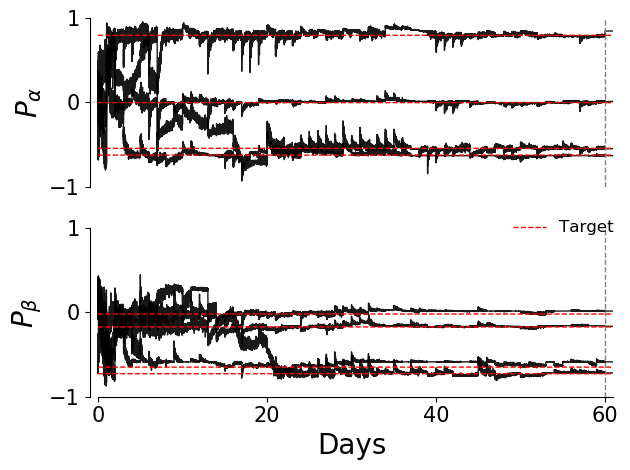

In [19]:
plot_output(obj)

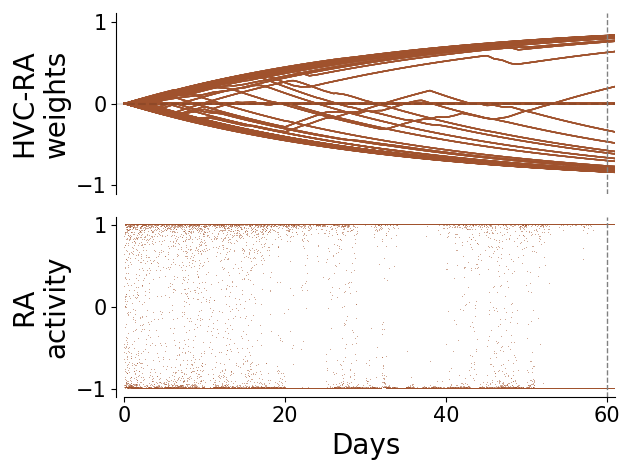

In [20]:
plot_HL(obj)

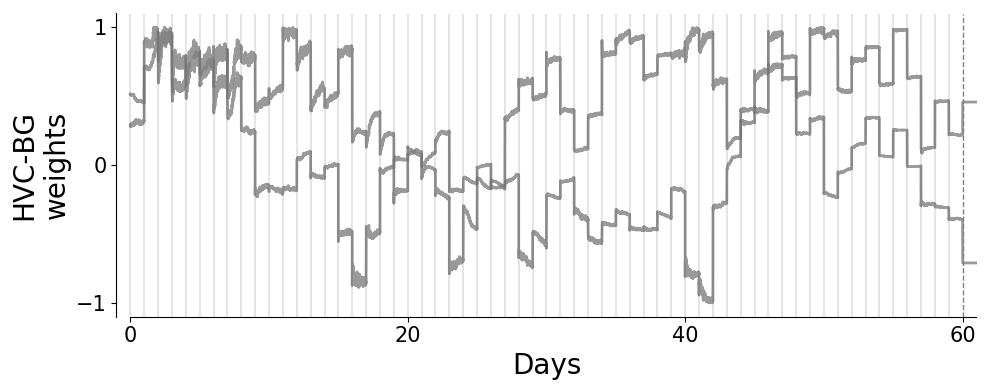

In [83]:
plot_BG_volatility(obj)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


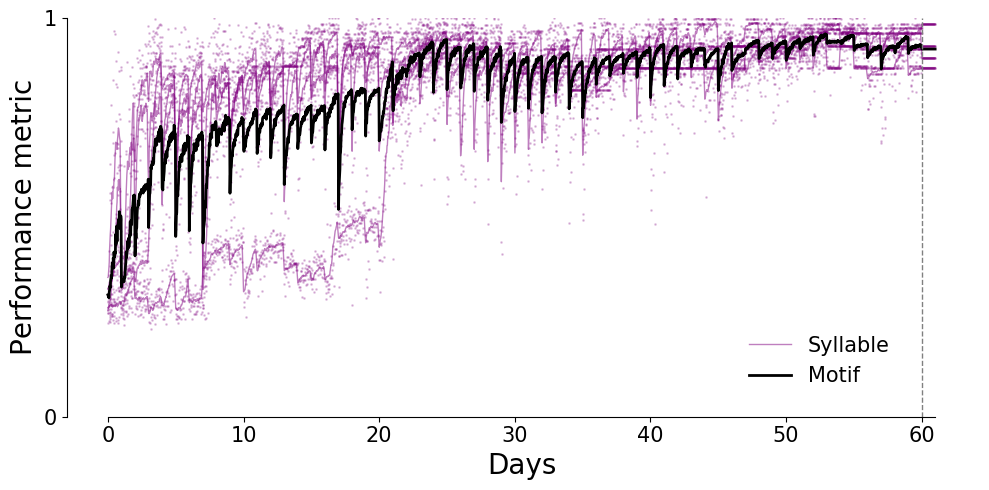

In [212]:
plot_reward(obj)


In [17]:
# s = int(obj.S_RA.shape)
# x = np.arange(s[0])
# y = np.arange((s[1]/50))
# cm = plt.cm.get_cmap('Reds')
# c = plt.pcolormesh(x, y, obj.S_RA[::,::50].T, vmin=-1, vmax=1, cmap=cm)
# plt.colorbar(c)

In [26]:
def plot_HL(obj):
        """ Plots the model output over time. """

        figure, (ax1, ax2) = plt.subplots(2,1)
        
        sk = obj.n_syllables

        # Display x axis in days
        x = np.arange(obj.n_total_trials)
        x = x/(obj.n_daily_motifs * obj.n_syllables)



        # Plot running average of cortical output (brown), BG output (grey) and total output (black)
#         ax1.plot(x[::10], obj.W_HR[::10,::10], color='sienna', alpha=.5, linewidth=1)
#         ax2.plot(x[::100], obj.S_RA[::100, ::10], color="sienna", alpha=.5, marker=',', linewidth=0, markersize=1)

#         ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
        
        ax1.axvline(x=60, linestyle='--', color='grey', lw=1)
        ax2.axvline(x=60, linestyle='--', color='grey', lw=1)
        
        
        
        cm = plt.cm.get_cmap('RdGy_r')
        im1 = ax1.imshow(obj.W_HR[::2000,:10].T,  cmap=cm, aspect='auto', extent=[0,61,0,10])
        im2 = ax2.imshow(obj.S_RA[::,::10].T,  cmap=cm, aspect='auto', extent=[0,61,0,10])
        
        figure.subplots_adjust(right=1.2)
        cbar_ax = figure.add_axes([1.05, 0.6, 0.03, 0.35])
        cbar = figure.colorbar(im2, cax=cbar_ax)
        cbar.set_label('Synaptic strength', fontsize=15)
        cbar.set_ticks([-1, 0, 1])
        
        
        
        figure.subplots_adjust(right=1.2)
        cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.35])
        cbar = figure.colorbar(im2, cax=cbar_ax)
        cbar.set_label('Activity level', fontsize=15)
        cbar.set_ticks([-1, 0, 1])



    
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.get_xaxis().set_ticks([])


        ax1.tick_params(labelsize=15)
        ax1.set_yticks([0, 10])
        ax1.set_xlim(-1, obj.n_days+obj.n_lesioned_days)
        ax1.set_ylim(0, 10)

        ax1.set_xlabel('Days', fontsize=20)
        ax1.get_xaxis().set_ticks([0, 20, 40, 60])
        ax1.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

        ax2.set_ylim(0, 10)
        ax2.set_xlabel('Days', fontsize=20)
        ax2.set_yticks([0, 10])
        ax2.tick_params(labelsize=15)
        ax2.set_xlim(-1, obj.n_days+obj.n_lesioned_days)
        ax2.get_xaxis().set_ticks([0, 20, 40, 60])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

        ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
        ax2.set_ylabel('RA\nunit', fontsize=20)

        plt.tight_layout()

            
        # Save figure
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_HL1.png", bbox_inches='tight')

        plt.show()
#         plt.close(figure)   

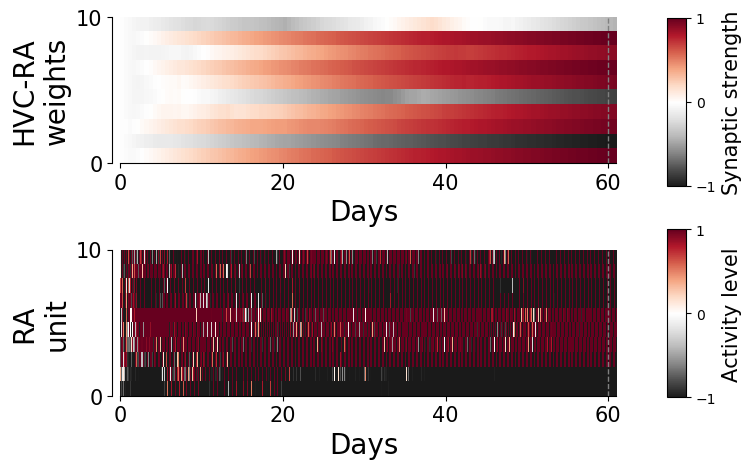

In [27]:
plot_HL(obj)

In [316]:
def plot_BG(obj):
        """ Plots the model output over time. """

        figure, (ax1, ax2) = plt.subplots(2,1)
        
        sk = obj.n_syllables

        # Display x axis in days
        x = np.arange(obj.n_total_trials)
        x = x/(obj.n_daily_motifs * obj.n_syllables)

        # Plot running average of cortical output (brown), BG output (grey) and total output (black)
#         ax1.plot(x[::10], obj.W[::2000,::1200], color='grey', alpha=.5, linewidth=1)
#         ax2.plot(x[::100], obj.S_BG[::, ::], color="grey", alpha=.5, marker=',', linewidth=0, markersize=1)
        
        
        
        
        
        cm = plt.cm.get_cmap('Greys')
        im1 = ax1.imshow(obj.W[::2000,:10].T,  cmap=cm, aspect='auto', extent=[0,61,0,10])
        im2 = ax2.imshow(obj.S_BG[::,::5].T,  cmap=cm, aspect='auto', extent=[0,61,0,10])
        
        figure.subplots_adjust(right=1.2)
        cbar_ax = figure.add_axes([1.05, 0.6, 0.03, 0.35])
        cbar = figure.colorbar(im1, cax=cbar_ax)
        cbar.set_label('Synaptic strength', fontsize=15)
        cbar.set_ticks([-1, 0, 1])
        
        
        
        figure.subplots_adjust(right=1.2)
        cbar_ax = figure.add_axes([1.05, 0.16, 0.03, 0.35])
        cbar = figure.colorbar(im2, cax=cbar_ax)
        cbar.set_label('Activity level', fontsize=15)
        cbar.set_ticks([-1, 0, 1])


        
        ax1.axvline(x=60, linestyle='--', color='grey', lw=1)
        ax2.axvline(x=60, linestyle='--', color='grey', lw=1)
        


        ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
#         ax1.axhline(y=obj.targetpos[0], linestyle='--', color='black', label='Global optimum')


        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.get_xaxis().set_ticks([])
        ax1.set_ylim(0, 10)
        ax1.tick_params(labelsize=15)
        ax1.set_yticks([0, 10])
        ax1.set_xlim(-1, obj.n_days+obj.n_lesioned_days)

        ax1.set_xlabel('Days', fontsize=20)
        ax1.get_xaxis().set_ticks([0, 20, 40, 60])
        ax1.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)



        ax2.set_ylim(0, 10)
        ax2.set_xlabel('Days', fontsize=20)
        ax2.set_yticks([0, 10])
        ax2.tick_params(labelsize=15)
        ax2.set_xlim(-1, obj.n_days+obj.n_lesioned_days)
        ax2.get_xaxis().set_ticks([0, 20, 40, 60])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

#         if obj.contour_type=='Syrinx':
#             ax1.set_ylabel(r'$P_{\beta} (Tension)$', fontsize=20)
#             ax1.set_ylabel(r'$P_{\alpha} (Pressure)$', fontsize=20)
#         else:
        ax1.set_ylabel('HVC-BG\nweights', fontsize=20)
#         ax2.set_ylabel('BG\nunit', fontsize=20)

#         ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
        
#         plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
        plt.tight_layout()



#         if obj.contour_type=='Syrinx':
#             ax1.set_yticklabels(np.linspace(obj.syrinx_param_range[2], obj.syrinx_param_range[3], 3))
#             ax1.set_yticklabels(np.linspace(obj.syrinx_param_range[0], obj.syrinx_param_range[1], 3))


            
        # Save figure
#         plt.savefig(self.fig_name + 'coordinates.' + self.img_format, format=self.img_format, bbox_inches='tight', rasterized=self.rasterized, dpi=self.dpi)
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_BG.png", bbox_inches='tight')


#         plt.close(figure)   

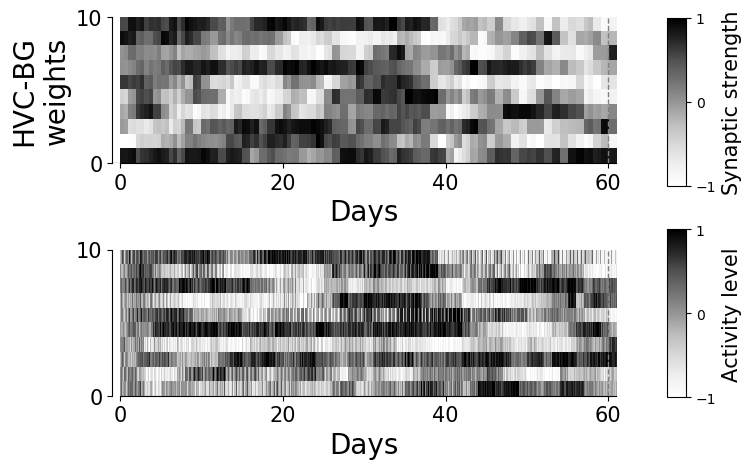

In [317]:
plot_BG(obj)

In [74]:
def plot_HL2_d60(obj):
        """ Plots the model output over time. """

        figure, (ax1) = plt.subplots(1,1, figsize=(6,5))
        
        sk = obj.n_syllables

        # Display x axis in days
        x = np.arange(obj.n_total_trials)
        x = x/(obj.n_daily_motifs * obj.n_syllables)



        # Plot running average of cortical output (brown), BG output (grey) and total output (black)
#         ax1.plot(x[::10], obj.W_HR[::10,::10], color='sienna', alpha=.5, linewidth=1)
#         ax2.plot(x[::100], obj.S_RA[::100, ::10], color="sienna", alpha=.5, marker=',', linewidth=0, markersize=1)

#         ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
        
#         ax1.axvline(x=60, linestyle='--', color='grey', lw=1)
#         ax2.axvline(x=60, linestyle='--', color='grey', lw=1)
        
        
        cm = plt.cm.get_cmap('RdGy_r')
#         im1 = ax1.imshow(obj.W_HR[::2000,:10].T,  cmap=cm, aspect='auto', extent=[0,61,0,10])
        kt=55
        im2 = ax1.imshow(obj.S_RA[-2*int(obj.n_daily_motifs * obj.n_syllables):-int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])
#         im2 = ax1.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])
#         kt=16
#         im2 = ax2.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])
#         kt=60
#         im2 = ax3.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])


        
        
        figure.subplots_adjust(right=1.2)
        cbar_ax = figure.add_axes([1.05, 0.2, 0.03, 0.53])
        cbar = figure.colorbar(im2, cax=cbar_ax)
        cbar.set_label('Firing rate', fontsize=15)
        cbar.set_ticks([-1, 0, 1])



    

        ax1.set_ylim(0, 1000)
#         ax3.set_xlabel('Syllable', fontsize=20)
        ax1.set_yticks([1000, 0])
        ax1.tick_params(labelsize=15)
        ax1.set_xlim(0, 4)
        ax1.get_xaxis().set_ticks([])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
#         ax1.spines['bottom'].set_visible(False)
#         ax1.text(4.2,750,'Neuron 3', fontsize=15, rotation=90)
        ax1.text(1.5,1200,'Day 60', fontsize=25, rotation=0)

        
        ax1.set_xlabel('Syllable', fontsize=20)
        ax1.set_xlim(0, 4)
        ax1.get_xaxis().set_ticks([0.5, 1.5, 2.5, 3.5])
        ax1.get_xaxis().set_ticklabels(['A', 'B', 'C', 'D'])


        

#         ax2.set_ylim(0, 1000)
# #         ax2.set_xlabel('Syllable', fontsize=20)
#         ax2.set_yticks([1000, 0])
#         ax2.tick_params(labelsize=15)
#         ax2.set_xlim(0, 4)
#         ax2.get_xaxis().set_ticks([])
#         ax2.spines['top'].set_visible(False)
#         ax2.spines['right'].set_visible(False)
#         ax2.spines['bottom'].set_visible(False)
#         ax2.text(4.2,900,'Neuron 2', fontsize=15, rotation=90)

        
#         ax3.set_ylim(0, 1000)
#         ax3.set_xlabel('Syllable', fontsize=20)
#         ax3.set_yticks([1000, 0])
#         ax3.tick_params(labelsize=15)
#         ax3.set_xlim(0, 4)
#         ax3.get_xaxis().set_ticks([0.5, 1.5, 2.5, 3.5])
#         ax3.get_xaxis().set_ticklabels(['A', 'B', 'C', 'D'])
#         ax3.spines['top'].set_visible(False)
#         ax3.spines['right'].set_visible(False)
#         ax3.text(4.2,900,'Neuron 1', fontsize=15, rotation=90)
#         ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

#         ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
        ax1.set_ylabel('Motif number', fontsize=20)

        plt.tight_layout()

            
        # Save figure
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_HL2_d60.png", bbox_inches='tight')

        plt.show()
#         plt.close(figure)   

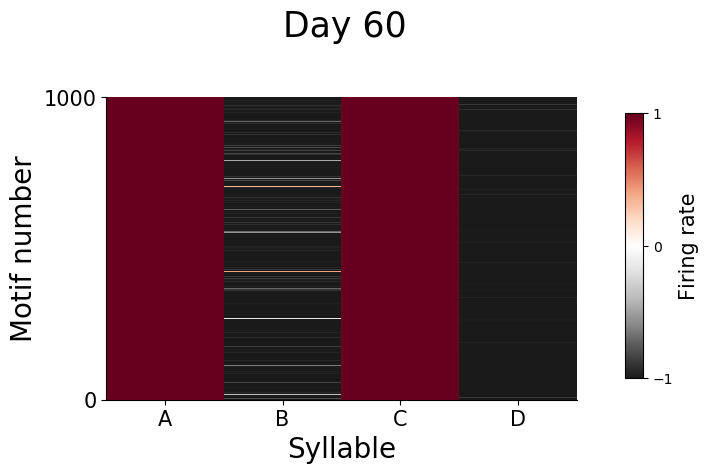

In [75]:
plot_HL2_d60(obj)

In [76]:
def plot_HL2_d1(obj):
        """ Plots the model output over time. """

        figure, (ax1) = plt.subplots(1,1, figsize=(6,5))
        
        sk = obj.n_syllables

        # Display x axis in days
        x = np.arange(obj.n_total_trials)
        x = x/(obj.n_daily_motifs * obj.n_syllables)



        # Plot running average of cortical output (brown), BG output (grey) and total output (black)
#         ax1.plot(x[::10], obj.W_HR[::10,::10], color='sienna', alpha=.5, linewidth=1)
#         ax2.plot(x[::100], obj.S_RA[::100, ::10], color="sienna", alpha=.5, marker=',', linewidth=0, markersize=1)

#         ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
        
#         ax1.axvline(x=60, linestyle='--', color='grey', lw=1)
#         ax2.axvline(x=60, linestyle='--', color='grey', lw=1)
        
        
        cm = plt.cm.get_cmap('RdGy_r')
#         im1 = ax1.imshow(obj.W_HR[::2000,:10].T,  cmap=cm, aspect='auto', extent=[0,61,0,10])
        kt=55
        im2 = ax1.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])
#         kt=16
#         im2 = ax2.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])
#         kt=60
#         im2 = ax3.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])


        
        
        figure.subplots_adjust(right=1.2)
        cbar_ax = figure.add_axes([1.05, 0.2, 0.03, 0.53])
        cbar = figure.colorbar(im2, cax=cbar_ax)
        cbar.set_label('Firing rate', fontsize=15)
        cbar.set_ticks([-1, 0, 1])



    

        ax1.set_ylim(0, 1000)
#         ax3.set_xlabel('Syllable', fontsize=20)
        ax1.set_yticks([1000, 0])
        ax1.tick_params(labelsize=15)
        ax1.set_xlim(0, 4)
        ax1.get_xaxis().set_ticks([])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
#         ax1.spines['bottom'].set_visible(False)
#         ax1.text(4.2,750,'Neuron 3', fontsize=15, rotation=90)
        ax1.text(1.5,1200,'Day 0', fontsize=25, rotation=0)

        
        ax1.set_xlabel('Syllable', fontsize=20)
        ax1.set_xlim(0, 4)
        ax1.get_xaxis().set_ticks([0.5, 1.5, 2.5, 3.5])
        ax1.get_xaxis().set_ticklabels(['A', 'B', 'C', 'D'])


        

#         ax2.set_ylim(0, 1000)
# #         ax2.set_xlabel('Syllable', fontsize=20)
#         ax2.set_yticks([1000, 0])
#         ax2.tick_params(labelsize=15)
#         ax2.set_xlim(0, 4)
#         ax2.get_xaxis().set_ticks([])
#         ax2.spines['top'].set_visible(False)
#         ax2.spines['right'].set_visible(False)
#         ax2.spines['bottom'].set_visible(False)
#         ax2.text(4.2,900,'Neuron 2', fontsize=15, rotation=90)

        
#         ax3.set_ylim(0, 1000)
#         ax3.set_xlabel('Syllable', fontsize=20)
#         ax3.set_yticks([1000, 0])
#         ax3.tick_params(labelsize=15)
#         ax3.set_xlim(0, 4)
#         ax3.get_xaxis().set_ticks([0.5, 1.5, 2.5, 3.5])
#         ax3.get_xaxis().set_ticklabels(['A', 'B', 'C', 'D'])
#         ax3.spines['top'].set_visible(False)
#         ax3.spines['right'].set_visible(False)
#         ax3.text(4.2,900,'Neuron 1', fontsize=15, rotation=90)
#         ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

#         ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
        ax1.set_ylabel('Motif number', fontsize=20)

        plt.tight_layout()

            
        # Save figure
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_HL2_d1.png", bbox_inches='tight')

        plt.show()
#         plt.close(figure)   

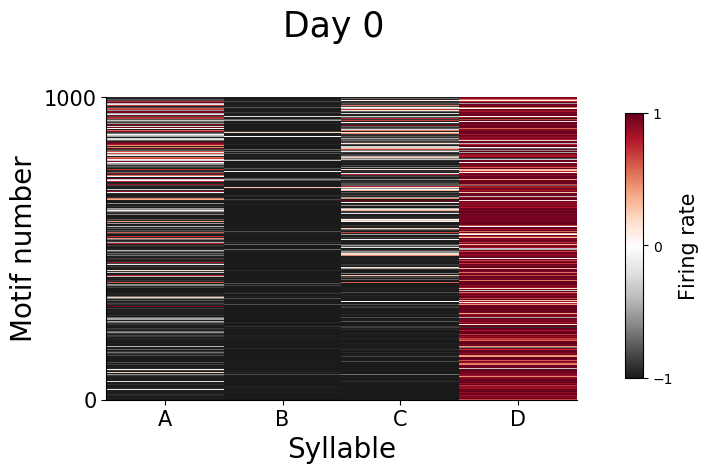

In [77]:
plot_HL2_d1(obj)

In [78]:
def plot_BG_d1(obj):
        """ Plots the model output over time. """

        figure, (ax1) = plt.subplots(1,1, figsize=(6,5))
        
        sk = obj.n_syllables

        # Display x axis in days
        x = np.arange(obj.n_total_trials)
        x = x/(obj.n_daily_motifs * obj.n_syllables)



        # Plot running average of cortical output (brown), BG output (grey) and total output (black)
#         ax1.plot(x[::10], obj.W_HR[::10,::10], color='sienna', alpha=.5, linewidth=1)
#         ax2.plot(x[::100], obj.S_RA[::100, ::10], color="sienna", alpha=.5, marker=',', linewidth=0, markersize=1)

#         ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
        
#         ax1.axvline(x=60, linestyle='--', color='grey', lw=1)
#         ax2.axvline(x=60, linestyle='--', color='grey', lw=1)
        
        
        cm = plt.cm.get_cmap('RdGy_r')
#         im1 = ax1.imshow(obj.W_HR[::2000,:10].T,  cmap=cm, aspect='auto', extent=[0,61,0,10])
        kt=45
        im2 = ax1.imshow(obj.S_BG[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])
#         kt=16
#         im2 = ax2.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])
#         kt=60
#         im2 = ax3.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])


        
        
        figure.subplots_adjust(right=1.2)
        cbar_ax = figure.add_axes([1.05, 0.2, 0.03, 0.53])
        cbar = figure.colorbar(im2, cax=cbar_ax)
        cbar.set_label('Firing rate', fontsize=15)
        cbar.set_ticks([-.3, 0, .3])




    

        ax1.set_ylim(0, 1000)
#         ax3.set_xlabel('Syllable', fontsize=20)
        ax1.set_yticks([1000, 0])
        ax1.tick_params(labelsize=15)
        ax1.set_xlim(0, 4)
        ax1.get_xaxis().set_ticks([])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
#         ax1.spines['bottom'].set_visible(False)
#         ax1.text(4.2,750,'Neuron 3', fontsize=15, rotation=90)
        ax1.text(1.5,1200,'Day 0', fontsize=25, rotation=0)

        
        ax1.set_xlabel('Syllable', fontsize=20)
        ax1.set_xlim(0, 4)
        ax1.get_xaxis().set_ticks([0.5, 1.5, 2.5, 3.5])
        ax1.get_xaxis().set_ticklabels(['A', 'B', 'C', 'D'])


        

#         ax2.set_ylim(0, 1000)
# #         ax2.set_xlabel('Syllable', fontsize=20)
#         ax2.set_yticks([1000, 0])
#         ax2.tick_params(labelsize=15)
#         ax2.set_xlim(0, 4)
#         ax2.get_xaxis().set_ticks([])
#         ax2.spines['top'].set_visible(False)
#         ax2.spines['right'].set_visible(False)
#         ax2.spines['bottom'].set_visible(False)
#         ax2.text(4.2,900,'Neuron 2', fontsize=15, rotation=90)

        
#         ax3.set_ylim(0, 1000)
#         ax3.set_xlabel('Syllable', fontsize=20)
#         ax3.set_yticks([1000, 0])
#         ax3.tick_params(labelsize=15)
#         ax3.set_xlim(0, 4)
#         ax3.get_xaxis().set_ticks([0.5, 1.5, 2.5, 3.5])
#         ax3.get_xaxis().set_ticklabels(['A', 'B', 'C', 'D'])
#         ax3.spines['top'].set_visible(False)
#         ax3.spines['right'].set_visible(False)
#         ax3.text(4.2,900,'Neuron 1', fontsize=15, rotation=90)
#         ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

#         ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
        ax1.set_ylabel('Motif number', fontsize=20)

        plt.tight_layout()

            
        # Save figure
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_BG_d1.png", bbox_inches='tight')

        plt.show()
#         plt.close(figure)   

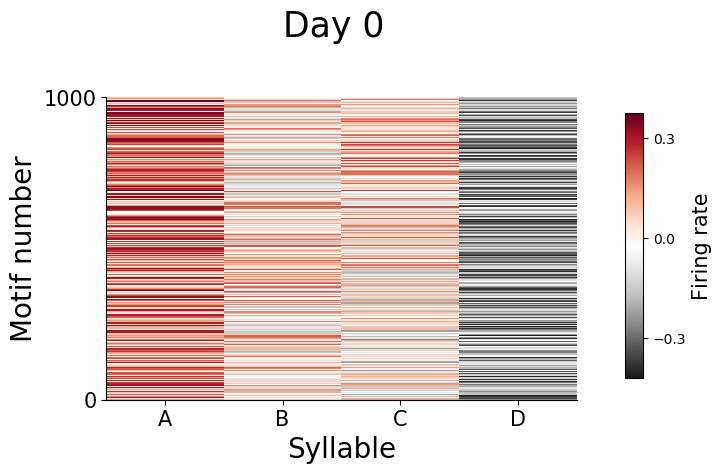

In [79]:
plot_BG_d1(obj)

In [80]:
def plot_BG_d60(obj):
        """ Plots the model output over time. """

        figure, (ax1) = plt.subplots(1,1, figsize=(6,5))
        
        sk = obj.n_syllables

        # Display x axis in days
        x = np.arange(obj.n_total_trials)
        x = x/(obj.n_daily_motifs * obj.n_syllables)



        # Plot running average of cortical output (brown), BG output (grey) and total output (black)
#         ax1.plot(x[::10], obj.W_HR[::10,::10], color='sienna', alpha=.5, linewidth=1)
#         ax2.plot(x[::100], obj.S_RA[::100, ::10], color="sienna", alpha=.5, marker=',', linewidth=0, markersize=1)

#         ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
        
#         ax1.axvline(x=60, linestyle='--', color='grey', lw=1)
#         ax2.axvline(x=60, linestyle='--', color='grey', lw=1)
        
        
        cm = plt.cm.get_cmap('RdGy_r')
#         im1 = ax1.imshow(obj.W_HR[::2000,:10].T,  cmap=cm, aspect='auto', extent=[0,61,0,10])
        kt=45
        im2 = ax1.imshow(obj.S_BG[-2*int(obj.n_daily_motifs * obj.n_syllables):-int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])

#         kt=16
#         im2 = ax2.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])
#         kt=60
#         im2 = ax3.imshow(obj.S_RA[:int(obj.n_daily_motifs * obj.n_syllables),kt:kt+1].reshape(1000,4),  cmap=cm, aspect='auto', extent=[0,4,0,1000])


        
        
        figure.subplots_adjust(right=1.2)
        cbar_ax = figure.add_axes([1.05, 0.2, 0.03, 0.53])
        cbar = figure.colorbar(im2, cax=cbar_ax)
        cbar.set_label('Firing rate', fontsize=15)
        cbar.set_ticks([-.3, 0, .3])



    

        ax1.set_ylim(0, 1000)
#         ax3.set_xlabel('Syllable', fontsize=20)
        ax1.set_yticks([1000, 0])
        ax1.tick_params(labelsize=15)
        ax1.set_xlim(0, 4)
        ax1.get_xaxis().set_ticks([])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
#         ax1.spines['bottom'].set_visible(False)
#         ax1.text(4.2,750,'Neuron 3', fontsize=15, rotation=90)
        ax1.text(1.5,1200,'Day 60', fontsize=25, rotation=0)

        
        ax1.set_xlabel('Syllable', fontsize=20)
        ax1.set_xlim(0, 4)
        ax1.get_xaxis().set_ticks([0.5, 1.5, 2.5, 3.5])
        ax1.get_xaxis().set_ticklabels(['A', 'B', 'C', 'D'])


        

#         ax2.set_ylim(0, 1000)
# #         ax2.set_xlabel('Syllable', fontsize=20)
#         ax2.set_yticks([1000, 0])
#         ax2.tick_params(labelsize=15)
#         ax2.set_xlim(0, 4)
#         ax2.get_xaxis().set_ticks([])
#         ax2.spines['top'].set_visible(False)
#         ax2.spines['right'].set_visible(False)
#         ax2.spines['bottom'].set_visible(False)
#         ax2.text(4.2,900,'Neuron 2', fontsize=15, rotation=90)

        
#         ax3.set_ylim(0, 1000)
#         ax3.set_xlabel('Syllable', fontsize=20)
#         ax3.set_yticks([1000, 0])
#         ax3.tick_params(labelsize=15)
#         ax3.set_xlim(0, 4)
#         ax3.get_xaxis().set_ticks([0.5, 1.5, 2.5, 3.5])
#         ax3.get_xaxis().set_ticklabels(['A', 'B', 'C', 'D'])
#         ax3.spines['top'].set_visible(False)
#         ax3.spines['right'].set_visible(False)
#         ax3.text(4.2,900,'Neuron 1', fontsize=15, rotation=90)
#         ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)

#         ax1.set_ylabel('HVC-RA\nweights', fontsize=20)
        ax1.set_ylabel('Motif number', fontsize=20)

        plt.tight_layout()

            
        # Save figure
        plt.savefig(obj.results_path + '/' + str(obj.rSeed) + "_BG_d60.png", bbox_inches='tight')

        plt.show()
#         plt.close(figure)   

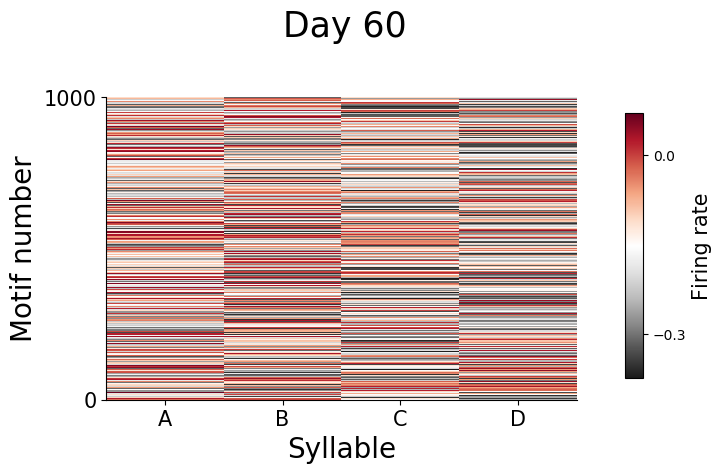

In [19]:
plot_BG_d60(obj)